<a href="https://colab.research.google.com/github/Alaalhumaidan/PhD/blob/main/HAR_Preprocessing_CNN-LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import librosa
import pickle
import librosa.display
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from collections import defaultdict
import re
import soundfile as sf
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import Audio
import numpy as np
import math
from collections import Counter
import json
import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten,TimeDistributed,Input,BatchNormalization,Dropout
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed
from keras.callbacks import Callback
from keras.utils import to_categorical
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
def extract_info_from_path(file_path):
    # Split the path into individual components
    components = file_path.split(os.path.sep)

    # Extract relevant information
    series = components[-4]  # Assuming "Series3" is always four levels from the end
    class_label = components[-3]
    sub_class_label = components[-2]

    return series, class_label, sub_class_label

In [ ]:
def remove_filename_from_path(file_path):
    # Split the path into directory and filename
    directory, filename = os.path.split(file_path)

    # Remove the filename from the directory path
    path_without_filename = os.path.join(directory, 'noise')
    # Check if the folder already exists before creating it
    if not os.path.exists(path_without_filename):
      os.makedirs(path_without_filename)
    return path_without_filename

In [ ]:
def load_from_directory_noise(directorypath,name):
    noise_audio = []
    noise_file = []
    sampling_rates = []
    noise_text = []
    for root, dirs, files in os.walk(directorypath):
        for file_name in files:
         if file_name.endswith(name):
            filespath = os.path.join(root, file_name)
            audio, sr = librosa.load(filespath, sr=None)
            normalized_audio = librosa.util.normalize(audio)
            noise_audio.append(normalized_audio)
            sampling_rates.append(sr)
            noise_file.append(filespath)
    return noise_audio,noise_file, sampling_rates

In [ ]:
def calculate_noise_factor(index,n):
    if index in range(0,n):
      noise_factor=0.01
    elif index in range(n,2*n):
      noise_factor=0.01+0.003
    else:
      noise_factor=0.01-0.003
    return noise_factor

In [ ]:
def augment_audio_with_noises(audio_file,path,sr, noise_factor,noise_types=['white','pink','brown','blue']):
    y, sr = audio_file,sr  # Load audio file
    augmented_audio=[]
    series, class_label, sub_class_label =extract_info_from_path(path)
    for noise_type in noise_types:
        if noise_type == 'white':
            noise = np.random.randn(len(y))  # Generate white noise
        elif noise_type == 'pink':
            noise = generate_pink_noise(len(y), sr)  # Generate pink noise
        elif noise_type == 'brown':
            noise = np.random.standard_normal(len(y))  # Generate brown noise
        elif noise_type == 'blue':
            noise = np.random.uniform(-1, 1, len(y))  # Generate blue noise
        else:
            raise ValueError(f"Noise type '{noise_type}' is not supported.")

        augmented_audio = y + noise_factor * noise  # Add noise to audio
        augmented_filename = f"augmented_{series}_{sub_class_label}_{noise_type}"
        output_path=remove_filename_from_path(path)
        augmented_file_path = os.path.join(output_path, augmented_filename)
        if not augmented_file_path.endswith('.wav'):
           augmented_file_path += '.wav'
        if os.path.exists(augmented_file_path):
           os.remove(augmented_file_path)
        sf.write(augmented_file_path, augmented_audio, sr,format='wav')
        # visualize_waveform(augmented_audio, sr=44100)

In [ ]:
def noise_fn(directory):
  audiofile1, audiopath1,sampling_rate1 = load_from_directory_noise(directory,"output.wav")
  print(len(audiofile1))
  total_audio_files = len(audiofile1)
  n = 3
  divide_noise=int(total_audio_files/n)
  for index,(aud_file,path) in enumerate(zip(audiofile1,audiopath1)):
      noise_factor=calculate_noise_factor(index,divide_noise)
      augment_audio_with_noises(audio_file=aud_file,path=path,sr=sampling_rate1[0],noise_factor=noise_factor)


In [ ]:
def generate_pink_noise(length, sample_rate):
    pink_noise = np.random.randn(length)
    pink_noise = np.cumsum(pink_noise)
    pink_noise -= np.mean(pink_noise)
    pink_noise /= np.max(np.abs(pink_noise))
    pink_noise = np.interp(np.arange(length), np.linspace(0, length, len(pink_noise)), pink_noise)
    pink_noise *= 0.1  # Adjust the amplitude as needed
    return pink_noise

In [ ]:
def check_number(path):
  divide_path_parts = path.split(os.sep)
  second_last_part = divide_path_parts[-2]
  match = re.search(r'(\d+)', second_last_part)
  if match:
    return_number = match.group(1)
    return return_number

In [ ]:
def load_from_directory(directorypath,name,test_train):
    test_audio = []
    train_audio = []
    test_file = []
    train_file = []
    sampling_rates = []
    train_text = []
    test_text = []
    for root, dirs, files in os.walk(directorypath):
        for file_name in files:
         if file_name.endswith(name):
            filespath = os.path.join(root, file_name)
            audio, sr = librosa.load(filespath, sr=None)
            if test_train=="Manual":
              number=int(check_number(filespath))
              if number > 8:
                test_audio.append(librosa.util.normalize(audio))
                test_file.append(filespath)
              else:
                train_audio.append(librosa.util.normalize(audio))
                train_file.append(filespath)
            else:
              train_audio.append(librosa.util.normalize(audio))
              train_file.append(filespath)
         if file_name.endswith(".txt"):
            filespath = os.path.join(root, file_name)
            if test_train=="Manual":
              number=int(check_number(filespath))
              if number > 8:
                test_text.append(filespath)
              else:
                train_text.append(filespath)
            else:
              train_text.append(filespath)
    return train_audio,test_audio,train_file,test_file,train_text,test_text

In [ ]:
from collections import defaultdict
import librosa
import os

def map_frame_to_labels(audio, text_out, window, hop, sampling_rate, audiopath):
    series1, class_label1, sub_class_label1 =extract_info_from_path(audiopath)
    window_path=f"{series1}_{sub_class_label1}"
    activity_map_fin = {}
    activity_map_final = []
    samples = len(audio)
    count = 0

    for starting_sample in range(0, samples - hop + 1, hop):
        start_time=starting_sample/sampling_rate
        ending_sample = starting_sample + window
        end_time=ending_sample/sampling_rate
        activity_map = defaultdict(int)
        activity_times = []

        for activity_start_time, activity_end_time, act_label in text_out:
            activity_starting_sample = int(activity_start_time * sampling_rate)
            activity_ending_sample = int(activity_end_time * sampling_rate)

            if starting_sample >= activity_starting_sample and ending_sample <= activity_ending_sample:
                activity_map[act_label] += 1
                activity_times.append((start_time, end_time))
                break
            elif ending_sample > activity_starting_sample and starting_sample < activity_ending_sample:
                inter_start = max(starting_sample, activity_starting_sample)
                inter_start_time=inter_start/sampling_rate
                inter_end = min(ending_sample, activity_ending_sample)
                inter_end_time=inter_end/sampling_rate
                inter_dur = inter_end - inter_start
                window_dur = ending_sample - starting_sample
                weight = inter_dur / window_dur
                activity_map[act_label] += weight
                activity_times.append((inter_start_time, inter_end_time))

        count += 1
        if not activity_map:
            continue

        # Collect all activities with their corresponding weights and times
        activities = [{"activity": act, "weight": weight, "time_range": time_range,"windowpath":window_path}
                      for act, weight, time_range in zip(activity_map.keys(), activity_map.values(), activity_times)]

        activity_map_fin[count] = activities

    return activity_map_fin

def map_label(textpath, audio, hop_length, win_length):
    activity_text_path = textpath
    audio_file = audio
    audiodata, sampling_rate = librosa.load(audio_file, sr=None)
    window = win_length
    hop = hop_length
    file_name_test = os.path.basename(audio_file)
    text_out = read_text(activity_text_path)  # You need to define the read_text function
    mapped_labels = map_frame_to_labels(audiodata, text_out, window, hop, sampling_rate, audio)
    return mapped_labels

In [ ]:
def create_windows(data_audio, framesize, hop):
    windows = []
    n_samples = len(data_audio)
    hamming_window = np.hamming(framesize)
    test_count=0
    for i in range(0, n_samples - framesize + 1, hop):
        test_count=test_count+1
        window = data_audio[i:i + framesize] * hamming_window
        windows.append(window)
    windows.append(windows[test_count-1])
    windows.append(windows[test_count-1])
    return windows

In [ ]:
def read_text(activity_text):
    activities = []
    with open(activity_text, 'r') as file:
        for lines in file:
            start, end, res_label = [col.strip() for col in (lines.strip().split('\t'))]
            activities.append((float(start), float(end), res_label))
    return activities

In [ ]:
# Define the activities for each category
def rem_extreme(original_dict):
    extreme_activities = {'screaming','asking help','bend scream'}
    normal_activities = {'drop spoon', 'silence','walking','bad','computer','coughing','feel bad','feel terrible','hungry','pickup/eat food'}
    # Initialize two dictionaries
    extreme_dict = {}
    normal_dict = {}
    extreme_keys = []
    normal_keys = []

    # Iterate through the original dictionary
    for key, activities_list in original_dict.items():
        # Extract the set of activities for the current key
        key_activities = set(entry['activity'] for entry in activities_list)

        # Check if there's at least one common activity with category1_activities
        if key_activities.intersection(extreme_activities):
            extreme_dict[key] = activities_list
            extreme_keys.append(key)
        else:
            normal_dict[key] = activities_list
            normal_keys.append(key)
    return extreme_dict,extreme_keys,normal_dict,normal_keys

In [ ]:
import os

def delete_pkl_files(directory):
    for filename in os.listdir(directory):
        if filename.endswith(".pkl"):
            filepath = os.path.join(directory, filename)
            os.remove(filepath)


In [ ]:
def create_tensor(train_audiofile,train_blue_audiofile,train_brown_audiofile,train_pink_audiofile,train_white_audiofile,train_textpath,train_audiopath,window_length,hop_length,sampling_rate,train_blue_audiopath):
  extreme_windows_tot=[]
  extreme_windows_blue_tot=[]
  extreme_windows_brown_tot=[]
  extreme_windows_pink_tot=[]
  extreme_windows_white_tot=[]
  normal_windows_tot=[]
  normal_windows_blue_tot=[]
  normal_windows_brown_tot=[]
  normal_windows_pink_tot=[]
  normal_windows_white_tot=[]
  extreme_labels=[]
  normal_labels=[]

  for data_audio,data_blue_audio,data_brown_audio,data_pink_audio,data_white_audio,text,audio,blue_audio in zip(train_audiofile,train_blue_audiofile,train_brown_audiofile,train_pink_audiofile,train_white_audiofile,train_textpath,train_audiopath,train_blue_audiopath):
    mapped_labels = map_label(text,audio,hop_length,window_length)
    extreme_dict,extreme_keys,normal_dict,normal_keys=rem_extreme(mapped_labels)
    audio_windows = create_windows(data_audio, window_length, hop_length)
    audio_windows_blue = create_windows(data_blue_audio, window_length, hop_length)
    audio_windows_brown = create_windows(data_brown_audio, window_length, hop_length)
    audio_windows_pink = create_windows(data_pink_audio, window_length, hop_length)
    audio_windows_white = create_windows(data_white_audio, window_length, hop_length)
    extreme_windows = []
    normal_windows = []
    extreme_windows_blue = []
    normal_windows_blue = []
    extreme_windows_brown = []
    normal_windows_brown = []
    extreme_windows_pink = []
    normal_windows_pink = []
    extreme_windows_white = []
    normal_windows_white = []
    for key in extreme_keys:
        extreme_windows.append(audio_windows[key-1])
        extreme_windows_blue.append(audio_windows_blue[key-1])
        extreme_windows_brown.append(audio_windows_brown[key-1])
        extreme_windows_pink.append(audio_windows_pink[key-1])
        extreme_windows_white.append(audio_windows_white[key-1])
    for key in normal_keys:
        normal_windows.append(audio_windows[key-1])
        normal_windows_blue.append(audio_windows_blue[key-1])
        normal_windows_brown.append(audio_windows_brown[key-1])
        normal_windows_pink.append(audio_windows_pink[key-1])
        normal_windows_white.append(audio_windows_white[key-1])
    extreme_windows_tot.append(extreme_windows)
    extreme_windows_blue_tot.append(extreme_windows_blue)
    extreme_windows_brown_tot.append(extreme_windows_brown)
    extreme_windows_pink_tot.append(extreme_windows_pink)
    extreme_windows_white_tot.append(extreme_windows_white)
    normal_windows_tot.append(normal_windows)
    normal_windows_blue_tot.append(normal_windows_blue)
    normal_windows_brown_tot.append(normal_windows_brown)
    normal_windows_pink_tot.append(normal_windows_pink)
    normal_windows_white_tot.append(normal_windows_white)
    extreme_labels.append(extreme_dict)
    normal_labels.append(normal_dict)
  # tensor_extreme_windows = np.array(extreme_windows_tot)
  # tensor_extreme_blue_windows = np.array(extreme_windows_blue_tot)
  # tensor_extreme_brown_windows = np.array(extreme_windows_brown_tot)
  # tensor_extreme_pink_windows = np.array(extreme_windows_pink_tot)
  # tensor_extreme_white_windows = np.array(extreme_windows_white_tot)
  # tensor_extreme_labels = np.array(extreme_labels)
  # tensor_normal_windows = np.array(normal_windows_tot)
  # tensor_normal_blue_windows = np.array(normal_windows_blue_tot)
  # tensor_normal_brown_windows = np.array(normal_windows_brown_tot)
  # tensor_normal_pink_windows = np.array(normal_windows_pink_tot)
  # tensor_normal_white_windows = np.array(normal_windows_white_tot)
  # tensor_normal_labels = np.array(normal_labels)
  tensor_data_and_labels_extreme = (extreme_windows_tot, extreme_labels)
  tensor_data_and_labels_blue_extreme = (extreme_windows_blue_tot, extreme_labels)
  tensor_data_and_labels_brown_extreme = (extreme_windows_brown_tot, extreme_labels)
  tensor_data_and_labels_pink_extreme = (extreme_windows_pink_tot, extreme_labels)
  tensor_data_and_labels_white_extreme = (extreme_windows_white_tot, extreme_labels)
  tensor_data_and_labels_normal = (normal_windows_tot, normal_labels)
  tensor_data_and_labels_blue_normal = (normal_windows_blue_tot, normal_labels)
  tensor_data_and_labels_brown_normal = (normal_windows_brown_tot, normal_labels)
  tensor_data_and_labels_pink_normal = (normal_windows_pink_tot, normal_labels)
  tensor_data_and_labels_white_normal = (normal_windows_white_tot, normal_labels)
  delete_pkl_files("/content/drive/MyDrive/HAR")
# Save extreme tensors
  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_extreme.pkl', 'wb') as f:
    pickle.dump(tensor_data_and_labels_extreme, f)
  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_blue_extreme.pkl', 'wb') as f:
    pickle.dump(tensor_data_and_labels_blue_extreme, f)

  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_brown_extreme.pkl', 'wb') as f:
      pickle.dump(tensor_data_and_labels_brown_extreme, f)

  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_pink_extreme.pkl', 'wb') as f:
      pickle.dump(tensor_data_and_labels_pink_extreme, f)

  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_white_extreme.pkl', 'wb') as f:
      pickle.dump(tensor_data_and_labels_white_extreme, f)

  # Save normal tensors
  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_normal.pkl', 'wb') as f:
      pickle.dump(tensor_data_and_labels_normal, f)

  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_blue_normal.pkl', 'wb') as f:
      pickle.dump(tensor_data_and_labels_blue_normal, f)

  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_brown_normal.pkl', 'wb') as f:
      pickle.dump(tensor_data_and_labels_brown_normal, f)

  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_pink_normal.pkl', 'wb') as f:
      pickle.dump(tensor_data_and_labels_pink_normal, f)

  with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_white_normal.pkl', 'wb') as f:
      pickle.dump(tensor_data_and_labels_white_normal, f)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_extreme.npz', tensor_data_and_labels_extreme=tensor_data_and_labels_extreme)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_normal.npz', tensor_data_and_labels_normal=tensor_data_and_labels_normal)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_blue_extreme.npz', tensor_data_and_labels_blue_extreme=tensor_data_and_labels_blue_extreme)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_blue_normal.npz', tensor_data_and_labels_blue_normal=tensor_data_and_labels_blue_normal)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_brown_extreme.npz', tensor_data_and_labels_brown_extreme=tensor_data_and_labels_brown_extreme)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_brown_normal.npz', tensor_data_and_labels_brown_normal=tensor_data_and_labels_brown_normal)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_pink_extreme.npz', tensor_data_and_labels_pink_extreme=tensor_data_and_labels_pink_extreme)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_pink_normal.npz', tensor_data_and_labels_pink_normal=tensor_data_and_labels_pink_normal)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_white_extreme.npz', tensor_data_and_labels_white_extreme=tensor_data_and_labels_white_extreme)
  # np.savez('/content/drive/MyDrive/HAR/tensor_data_and_labels_white_normal.npz', tensor_data_and_labels_white_normal=tensor_data_and_labels_white_normal)

In [ ]:
def process(directory, window_length,hop_length,test_train):
  sampling_rate=44100
  train_audiofile, test_audiofile,train_audiopath,test_audiopath,train_textpath,test_textpath = load_from_directory(directory,"output.wav",test_train)
  train_blue_audiofile, test_blue_audiofile,train_blue_audiopath,test_blue_audiopath,train_blue_textpath,test_blue_textpath = load_from_directory(directory,"blue.wav",test_train)
  train_brown_audiofile, test_brown_audiofile,train_brown_audiopath,test_brown_audiopath,train_brown_textpath,test_brown_textpath = load_from_directory(directory,"brown.wav",test_train)
  train_pink_audiofile, test_pink_audiofile,train_pink_audiopath,test_pink_audiopath,train_pink_textpath,test_pink_textpath = load_from_directory(directory,"pink.wav",test_train)
  train_white_audiofile, test_white_audiofile,train_white_audiopath,test_white_audiopath,train_white_textpath,test_white_textpath = load_from_directory(directory,"white.wav",test_train)
  if test_train=="Manual":
     create_tensor(train_audiofile,train_textpath,train_audiopath,window_length,hop_length,sampling_rate)

  else:
     create_tensor(train_audiofile,train_blue_audiofile,train_brown_audiofile,train_pink_audiofile,train_white_audiofile,train_textpath,train_audiopath,window_length,hop_length,sampling_rate,train_blue_audiopath)


In [ ]:
def main(directory, window_length,test_train):
  hop_length=int(window_length/2)
  # noise_fn(directory)
  process(directory, window_length,hop_length,test_train)

In [ ]:
main("/content/drive/MyDrive/HAR/Files/",17640,"Auto")

In [ ]:

# with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_extreme.pkl', 'rb') as f:
#     tensor_data_and_labels_extreme_loaded = pickle.load(f)

# with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_blue_extreme.pkl', 'rb') as f:
#     tensor_data_and_labels_blue_extreme_loaded = pickle.load(f)

# with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_brown_extreme.pkl', 'rb') as f:
#     tensor_data_and_labels_brown_extreme_loaded = pickle.load(f)

# with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_pink_extreme.pkl', 'rb') as f:
#     tensor_data_and_labels_pink_extreme_loaded = pickle.load(f)

# with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_white_extreme.pkl', 'rb') as f:
#     tensor_data_and_labels_white_extreme_loaded = pickle.load(f)

# Load normal tensors
with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_normal.pkl', 'rb') as f:
    tensor_data_and_labels_normal_loaded = pickle.load(f)

with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_blue_normal.pkl', 'rb') as f:
    tensor_data_and_labels_blue_normal_loaded = pickle.load(f)

with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_brown_normal.pkl', 'rb') as f:
    tensor_data_and_labels_brown_normal_loaded = pickle.load(f)

with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_pink_normal.pkl', 'rb') as f:
    tensor_data_and_labels_pink_normal_loaded = pickle.load(f)

with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_white_normal.pkl', 'rb') as f:
    tensor_data_and_labels_white_normal_loaded = pickle.load(f)
white_normal_data_loaded, white_normal_label_loaded = tensor_data_and_labels_white_normal_loaded
pink_normal_data_loaded, pink_normal_label_loaded = tensor_data_and_labels_pink_normal_loaded
brown_normal_data_loaded, brown_normal_label_loaded = tensor_data_and_labels_brown_normal_loaded
blue_normal_data_loaded, blue_normal_label_loaded = tensor_data_and_labels_blue_normal_loaded
normal_data_loaded, normal_label_loaded = tensor_data_and_labels_normal_loaded

In [ ]:
print(len(normal_label_loaded))

301


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

windows_sv, labels_sv = normal_data_loaded, normal_label_loaded
list_of_lists = [list(d.values()) for d in labels_sv]
# print(len(list_of_lists))
activity_counts2 = {}

for inner_list2 in list_of_lists:
    for dictionary2 in inner_list2:
        activity2 = dictionary2[0]['activity']
        if activity2 in activity_counts2:
            activity_counts2[activity2] += 1
        else:
            activity_counts2[activity2] = 1

print(activity_counts2)
activities_to_remove = ['bad', 'feel terrible', 'computer']
# Filter out activities you want to remove
filtered_labels_sv = [
    {
        key: entries
        for key, entries in data_dict.items()
        if not any(entry['activity'] in activities_to_remove for entry in entries)
    }
    for data_dict in labels_sv
]
# Accessing a specific data point (windows and labels)
windows_blue, labels_blue = blue_normal_data_loaded, blue_normal_label_loaded
# Filter out activities you want to remove
# filtered_labels_blue = [
#     {
#         key1: entries1
#         for key1, entries1 in data_dict1.items()
#         if not any(entry1['activity'] in activities_to_remove for entry1 in entries1)
#     }
#     for data_dict1 in labels_blue
# ]
windows_brown, labels_brown = brown_normal_data_loaded, brown_normal_label_loaded
# Filter out activities you want to remove
# filtered_labels_brown = [
#     {
#         key2: entries2
#         for key2, entries2 in data_dict2.items()
#         if not any(entry2['activity'] in activities_to_remove for entry2 in entries2)
#     }
#     for data_dict2 in labels_brown
# ]
windows_pink, labels_pink = pink_normal_data_loaded, pink_normal_label_loaded
# Filter out activities you want to remove
# filtered_labels_pink = [
#     {
#         key3: entries3
#         for key3, entries3 in data_dict3.items()
#         if not any(entry3['activity'] in activities_to_remove for entry3 in entries3)
#     }
#     for data_dict3 in labels_pink
# ]
windows_white, labels_white = white_normal_data_loaded, white_normal_label_loaded
# # Filter out activities you want to remove
# filtered_labels_white = [
#     {
#         key4: entries4
#         for key4, entries4 in data_dict4.items()
#         if not any(entry4['activity'] in activities_to_remove for entry4 in entries4)
#     }
#     for data_dict4 in labels_white
# ]
# # Flatten the list of dictionaries into a list of activities
# all_activities = [entry5['activity'] for data_dict5 in labels_sv for key5, entries5 in data_dict5.items() for entry5 in entries5]
# # Count the occurrences of each activity
# activity_counts = Counter(all_activities)

# # Extract activity names and corresponding counts
# # activity_names, counts = zip(*activity_counts.items())

# # # Plot the histogram with rotated x-axis labels
# fig, ax = plt.subplots()
# bars = plt.bar(activity_names, counts)

# # # Annotate each bar with its count
# for bar, count in zip(bars, counts):
#     height = bar.get_height()
#     ax.annotate(f'{count}',
#                 xy=(bar.get_x() + bar.get_width() / 2, height),
#                 xytext=(0, 3),  # 3 points vertical offset for better readability
#                 textcoords='offset points',
#                 ha='center', va='bottom')

# plt.xlabel('Activity')
# plt.ylabel('Count')
# plt.title('Activity Histogram with Counts')
# plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
# plt.tight_layout()  # Adjust layout for better visualization
# plt.show()

{'silence': 4968, 'pickup/eat food': 1618, 'coughing': 754, 'hungry': 324, 'walking': 708, 'bad': 18, 'feel bad': 346, 'feel terrible': 3, 'drop spoon': 236, 'computer': 5}


In [ ]:
def flatten(lst):
    flattened_list = []
    for item in lst:
        if isinstance(item, list):
            flattened_list.extend(flatten(item))
        else:
            flattened_list.append(item)
    return flattened_list

In [ ]:
data_counter = activity_counts2
target_num_samples = 600 # 800
selected_windows=[]
selected_labels=[]
selected_labels_brown_final=[]
selected_windows_brown_final=[]
selected_labels_pink_final=[]
selected_windows_pink_final=[]
selected_windows_white_final=[]
selected_labels_white_final=[]

for activity, count in data_counter.items():
  if activity not in (activities_to_remove):
    selected_windows_blue = []
    selected_labels_blue=[]
    selected_windows_brown=[]
    selected_labels_brown=[]
    selected_windows_pink=[]
    selected_labels_pink=[]
    selected_windows_white=[]
    selected_labels_white=[]
    selected_windows_sv=[]
    selected_labels_sv=[]
    if count < target_num_samples:
        num_noise_samples = target_num_samples - count
        num_noise_samples_each_type=math.ceil(num_noise_samples/4)
        for window_blue,label_blue in zip(windows_blue,labels_blue):
          for window_lst,label_dict in zip(window_blue,label_blue.items()):
            for label_entry in label_dict[1]:
                if label_entry['activity'] == activity and label_entry['weight'] == 1:
                   selected_windows_blue.append(window_lst)
                   selected_labels_blue.append(label_dict)
        for window_brown,label_brown in zip(windows_brown,labels_brown):
          for window_2nd,label_dict_br in zip(window_brown,label_brown.items()):
            for label_entry_brown in label_dict_br[1]:
                if label_entry_brown['activity'] == activity and label_entry_brown['weight'] == 1:
                   selected_windows_brown.append(window_2nd)
                   selected_labels_brown.append(label_dict_br)
        for window_pink,label_pink in zip(windows_pink,labels_pink):
                  for window_3rd,label_dict_pk in zip(window_pink,label_pink.items()):
                    for label_entry_pink in label_dict_pk[1]:
                        if label_entry_pink['activity'] == activity and label_entry_pink['weight'] == 1:
                          selected_windows_pink.append(window_3rd)
                          selected_labels_pink.append(label_dict_pk)
        for window_white,label_white in zip(windows_white,labels_white):
                  for window_4th,label_dict_wh in zip(window_white,label_white.items()):
                    for label_entry_white in label_dict_wh[1]:
                        if label_entry_white['activity'] == activity and label_entry_white['weight'] == 1:
                          selected_windows_white.append(window_4th)
                          selected_labels_white.append(label_dict_wh)
        # print(selected_labels_white)
        blue_indices = np.random.choice(len(selected_windows_blue), num_noise_samples_each_type, replace=True)
        for i in blue_indices:
          selected_windows.append(selected_windows_blue[i])
          selected_labels.append(selected_labels_blue[i])
        brown_indices = np.random.choice(len(selected_windows_brown), num_noise_samples_each_type, replace=True)
        for i in brown_indices:
          selected_windows.append(selected_windows_brown[i])
          selected_labels.append(selected_labels_brown[i])
        pink_indices = np.random.choice(len(selected_windows_pink), num_noise_samples_each_type, replace=True)
        for i in pink_indices:
          selected_windows.append(selected_windows_pink[i])
          selected_labels.append(selected_labels_pink[i])
        white_indices = np.random.choice(len(selected_windows_white), num_noise_samples_each_type, replace=True)
        for i in white_indices:
          selected_windows.append(selected_windows_white[i])
          selected_labels.append(selected_labels_white[i])



    elif count >target_num_samples:
      target=400
      for window_sv,label_sv in zip(windows_sv,labels_sv):
                  for window_sv_fin,label_dict_sv in zip(window_sv,label_sv.items()):
                    for label_entry_sv in label_dict_sv[1]:
                        if label_entry_sv['activity'] == activity and label_entry_sv['weight'] != 1:
                          selected_windows_sv.append(window_sv_fin)
                          selected_labels_sv.append(label_dict_sv)
      if len(selected_windows_sv)<400:
        for window_sv,label_sv in zip(windows_sv,labels_sv):
                  for window_sv_fin,label_dict_sv in zip(window_sv,label_sv.items()):
                    for label_entry_sv in label_dict_sv[1]:
                        if label_entry_sv['activity'] == activity and label_entry_sv['weight'] == 1:
                          selected_windows_sv.append(window_sv_fin)
                          selected_labels_sv.append(label_dict_sv)
                          if len(selected_windows_sv) == 400:
                              break
                    if len(selected_windows_sv) == 400:
                              break
                  if len(selected_windows_sv) == 400:
                              break
      activity_indices = np.random.choice(len(selected_windows_sv), target, replace=True)
      for i in activity_indices:
          selected_windows.append(selected_windows_sv[i])
          selected_labels.append(selected_labels_sv[i])
      target_noise=200
      for window_blue,label_blue in zip(windows_blue,labels_blue):
          for window_lst,label_dict in zip(window_blue,label_blue.items()):
            for label_entry in label_dict[1]:
                if label_entry['activity'] == activity and label_entry['weight'] == 1:
                   selected_windows_blue.append(window_lst)
                   selected_labels_blue.append(label_dict)
      for window_brown,label_brown in zip(windows_brown,labels_brown):
        for window_2nd,label_dict_br in zip(window_brown,label_brown.items()):
          for label_entry_brown in label_dict_br[1]:
              if label_entry_brown['activity'] == activity and label_entry_brown['weight'] == 1:
                  selected_windows_brown.append(window_2nd)
                  selected_labels_brown.append(label_dict_br)
      for window_pink,label_pink in zip(windows_pink,labels_pink):
                for window_3rd,label_dict_pk in zip(window_pink,label_pink.items()):
                  for label_entry_pink in label_dict_pk[1]:
                      if label_entry_pink['activity'] == activity and label_entry_pink['weight'] == 1:
                        selected_windows_pink.append(window_3rd)
                        selected_labels_pink.append(label_dict_pk)
      for window_white,label_white in zip(windows_white,labels_white):
                for window_4th,label_dict_wh in zip(window_white,label_white.items()):
                  for label_entry_white in label_dict_wh[1]:
                      if label_entry_white['activity'] == activity and label_entry_white['weight'] == 1:
                        selected_windows_white.append(window_4th)
                        selected_labels_white.append(label_dict_wh)
      num_noise_samples_each_type1=math.ceil(target_noise/4)
      blue_indices = np.random.choice(len(selected_windows_blue), num_noise_samples_each_type1, replace=True)
      for i in blue_indices:
        selected_windows.append(selected_windows_blue[i])
        selected_labels.append(selected_labels_blue[i])
      brown_indices = np.random.choice(len(selected_windows_brown), num_noise_samples_each_type1, replace=True)
      for i in brown_indices:
        selected_windows.append(selected_windows_brown[i])
        selected_labels.append(selected_labels_brown[i])
      pink_indices = np.random.choice(len(selected_windows_pink), num_noise_samples_each_type1, replace=True)
      for i in pink_indices:
        selected_windows.append(selected_windows_pink[i])
        selected_labels.append(selected_labels_pink[i])
      white_indices = np.random.choice(len(selected_windows_white), num_noise_samples_each_type1, replace=True)
      for i in white_indices:
        selected_windows.append(selected_windows_white[i])
        selected_labels.append(selected_labels_white[i])
# list_of_lists = [list(d.values()) for d in labels_sv]
list_of_lists_of_dicts = [lst for _, lst in selected_labels]
print(len(selected_windows))
print(len(list_of_lists_of_dicts))
# # windows_sv.append(selected_windows)
# list_of_lists.append(list_of_lists_of_dicts)
activity_counts1 = {}

for inner_list in list_of_lists_of_dicts:
    for dictionary in inner_list:
        activity1 = dictionary['activity']
        if activity1 in activity_counts1:
            activity_counts1[activity1] += 1
        else:
            activity_counts1[activity1] = 1
# count_last=count_final(selected_labels)
print(activity_counts1)


3296
3296
{'silence': 1053, 'pickup/eat food': 776, 'hungry': 428, 'drop spoon': 498, 'coughing': 837, 'feel bad': 319, 'walking': 654, 'feel terrible': 1, 'computer': 2, 'bad': 2}


In [ ]:
for activityf, countf in activity_counts1.items():
  if activityf not in (activities_to_remove):
    selected_windows_blue = []
    selected_labels_blue=[]
    selected_windows_brown=[]
    selected_labels_brown=[]
    selected_windows_pink=[]
    selected_labels_pink=[]
    selected_windows_white=[]
    selected_labels_white=[]
    selected_windows_sv=[]
    selected_labels_sv=[]
    if countf < target_num_samples:
        num_noise_samples = target_num_samples - countf
        num_noise_samples_each_type=math.ceil(num_noise_samples/4)
        for window_blue,label_blue in zip(windows_blue,labels_blue):
          for window_lst,label_dict in zip(window_blue,label_blue.items()):
            for label_entry in label_dict[1]:
                if label_entry['activity'] == activityf and label_entry['weight'] == 1:
                   selected_windows_blue.append(window_lst)
                   selected_labels_blue.append(label_dict)
        for window_brown,label_brown in zip(windows_brown,labels_brown):
          for window_2nd,label_dict_br in zip(window_brown,label_brown.items()):
            for label_entry_brown in label_dict_br[1]:
                if label_entry_brown['activity'] == activityf and label_entry_brown['weight'] == 1:
                   selected_windows_brown.append(window_2nd)
                   selected_labels_brown.append(label_dict_br)
        for window_pink,label_pink in zip(windows_pink,labels_pink):
                  for window_3rd,label_dict_pk in zip(window_pink,label_pink.items()):
                    for label_entry_pink in label_dict_pk[1]:
                        if label_entry_pink['activity'] == activityf and label_entry_pink['weight'] == 1:
                          selected_windows_pink.append(window_3rd)
                          selected_labels_pink.append(label_dict_pk)
        for window_white,label_white in zip(windows_white,labels_white):
                  for window_4th,label_dict_wh in zip(window_white,label_white.items()):
                    for label_entry_white in label_dict_wh[1]:
                        if label_entry_white['activity'] == activityf and label_entry_white['weight'] == 1:
                          selected_windows_white.append(window_4th)
                          selected_labels_white.append(label_dict_wh)
        # print(selected_labels_white)
        blue_indices = np.random.choice(len(selected_windows_blue), num_noise_samples_each_type, replace=True)
        for i in blue_indices:
          if not any(np.array_equal(selected_windows_blue[i], window) for window in selected_windows):
            selected_windows.append(selected_windows_blue[i])
            selected_labels.append(selected_labels_blue[i])
        brown_indices = np.random.choice(len(selected_windows_brown), num_noise_samples_each_type, replace=True)
        for i in brown_indices:
          if not any(np.array_equal(selected_windows_brown[i], window) for window in selected_windows):
            selected_windows.append(selected_windows_brown[i])
            selected_labels.append(selected_labels_brown[i])
        pink_indices = np.random.choice(len(selected_windows_pink), num_noise_samples_each_type, replace=True)
        for i in pink_indices:
          if not any(np.array_equal(selected_windows_pink[i], window) for window in selected_windows):
            selected_windows.append(selected_windows_pink[i])
            selected_labels.append(selected_labels_pink[i])
        white_indices = np.random.choice(len(selected_windows_white), num_noise_samples_each_type, replace=True)
        for i in white_indices:
          if not any(np.array_equal(selected_windows_white[i], window) for window in selected_windows):
            selected_windows.append(selected_windows_white[i])
            selected_labels.append(selected_labels_white[i])
list_of_lists_of_dicts1 = [lst for _, lst in selected_labels]
# # windows_sv.append(selected_windows)
# list_of_lists.append(list_of_lists_of_dicts)
activity_counts7 = {}

for inner_list in list_of_lists_of_dicts:
    for dictionary in inner_list:
        activity7 = dictionary['activity']
        if activity7 in activity_counts7:
            activity_counts7[activity7] += 1
        else:
            activity_counts7[activity7] = 1
# count_last=count_final(selected_labels)
print(activity_counts7)
print(len(selected_windows))
print(len(list_of_lists_of_dicts1))
tensor_data_and_labels_normal_balanced = (selected_windows, list_of_lists_of_dicts1)
with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_normal_balanced.pkl', 'wb') as f:
    pickle.dump(tensor_data_and_labels_normal_balanced, f)

{'silence': 1053, 'pickup/eat food': 776, 'hungry': 428, 'drop spoon': 498, 'coughing': 837, 'feel bad': 319, 'walking': 654, 'feel terrible': 1, 'computer': 2, 'bad': 2}
3563
3563


In [ ]:
with open('/content/drive/MyDrive/HAR/tensor_data_and_labels_normal_balanced.pkl', 'rb') as f:
    tensor_data_and_labels_white_normal_balanced_loaded = pickle.load(f)
normal_data_balanced_loaded, normal_label_balanced_loaded = tensor_data_and_labels_white_normal_balanced_loaded



In [ ]:
def find_highest_suffix(output_folder, spec_filename):
    suffix = 1
    while True:
        # Generate the next output folder with an incremented suffix
        output_folder_with_suffix = f"{os.path.join(output_folder, spec_filename)}_{suffix}"

        # Check if the folder with the current suffix exists
        if not os.path.exists(output_folder_with_suffix):
            break

        # Increment the suffix number
        suffix += 1

    return suffix

def spectrogram(x,y, n_fft,hop_length, win_length,output_folder):
    X = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    Xdb = librosa.amplitude_to_db(abs(X))
    # print(Xdb.shape)
    # spec_filename=y[0]['windowpath']
    # spec_path = os.path.join(output_folder, spec_filename)
    # if os.path.exists(spec_path):
    #     # Find the highest suffix for the current spec_filename
    #     suffix = find_highest_suffix(output_folder, spec_filename)
    #     spec_path = f"{os.path.join(output_folder, spec_filename)}_{suffix}"

    # # Create the output folder
    # os.makedirs(spec_path)
    # file_name= "data.json"
    # file_path= os.path.join(spec_path, file_name)
    # with open(file_path, "w") as file:
    #    json.dump(y, file)
    # Plot the spectrogram
    # plt.figure(figsize=(14, 5))
    # librosa.display.specshow(Xdb, sr=44100, x_axis='time', y_axis='hz')
    # plt.colorbar()
    # filename = os.path.join(output_folder, spec_filename)
    # plt.savefig(os.path.join(spec_path, spec_filename + ".png"), bbox_inches='tight')
    # plt.close()  # Close the plot to release memory
    return Xdb


In [ ]:
import os
import shutil


def check_and_manage_folder(folder_path):
    # Check if the folder exists
    if os.path.exists(folder_path):
        # If the folder exists, delete its contents first
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            try:
                if os.path.isfile(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Failed to delete {file_path}. Reason: {e}")

        try:
            # Remove the folder itself
            os.rmdir(folder_path)
            print(f"Folder '{folder_path}' and its contents have been deleted.")
        except Exception as e:
            print(f"Failed to delete folder '{folder_path}'. Reason: {e}")

    # Create the folder
    try:
        os.makedirs(folder_path)
        print(f"Folder '{folder_path}' has been created.")
    except Exception as e:
        print(f"Failed to create folder '{folder_path}'. Reason: {e}")


In [ ]:
n_fft = 2048  # FFT size
win_length = 1024  # Window size
hop_length = int(win_length/2)  # Hop length
output_folder="/content/drive/MyDrive/HAR/Spectrogram"
# check_and_manage_folder(output_folder)
# audio_files = ["path/to/audio1.wav", "path/to/audio2.wav", ...]
spectrograms_all = []

for x,y in zip(normal_data_balanced_loaded,normal_label_balanced_loaded):
  spectrograms_all.append(spectrogram(x=x,y=y,n_fft=n_fft,hop_length=hop_length, win_length=win_length,output_folder="/content/drive/MyDrive/HAR/Spectrogram"))
  # spectrogram(x=x,y=y,n_fft=n_fft,hop_length=hop_length, win_length=win_length,output_folder="/content/drive/MyDrive/HAR/Spectrogram")



In [ ]:
from sklearn.preprocessing import LabelEncoder
unique_activities = set()

# Iterate over each dictionary in the list and add the "activity" key to the set
for item in normal_label_balanced_loaded:
# for item in label_test:
    for subitem in item:
       unique_activities.add(subitem['activity'])

# Convert the set to a list
unique_activities_list = list(unique_activities)

print(unique_activities_list)


# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform class labels
encoded_labels = label_encoder.fit_transform(unique_activities_list)

print("Original labels:", unique_activities_list)
print("Encoded labels:", encoded_labels)

# # Inverse transform to get back original labels from encoded labels
# decoded_labels = label_encoder.inverse_transform(encoded_labels)
# print("Decoded labels:", decoded_labels)

['feel bad', 'silence', 'bad', 'drop spoon', 'coughing', 'walking', 'hungry', 'pickup/eat food', 'feel terrible']
Original labels: ['feel bad', 'silence', 'bad', 'drop spoon', 'coughing', 'walking', 'hungry', 'pickup/eat food', 'feel terrible']
Encoded labels: [3 7 0 2 1 8 5 6 4]


In [ ]:
def create_label_vector(labels, num_time_bins, audio_file_start_time, bin_duration,encoded_labels):
    label_vector = []

    # Iterate over each time bin
    for i in range(num_time_bins):
        bin_start_time = audio_file_start_time + i * bin_duration
        bin_end_time = bin_start_time + bin_duration

        # Find labels that overlap with the current time bin
        overlapping_labels = [label['activity'] for label in labels if label['time_range'][0] <= bin_end_time and label['time_range'][1] >= bin_start_time]

        # Assign a label to the time bin based on certain criteria
        if overlapping_labels:
            label = overlapping_labels[0]
            encoded_label = label_encoder.transform([label])[0]
            # For simplicity, let's just take the first overlapping label
            label_vector.append(encoded_label)
        else:
            # If no label overlaps with the time bin, assign a default label (e.g., "silence")
            label_vector.append(-1)  # You can adjust this as needed

    return label_vector

# Example usage:
num_time_bins = 35  # Number of time bins in the spectrogram
bin_duration = 0.4 / num_time_bins  # Duration of each time bin (400 ms divided by the number of time bins)
encoded_labels=encoded_labels
y_all=[]
for y in normal_label_balanced_loaded:
# labels = [{'activity': 'pickup/eat food', 'weight': 0.548469387755102, 'time_range': (2.4, 2.619387755102041), 'windowpath': 'Series2_SM23'}, {'activity': 'silence', 'weight': 0.45153061224489793, 'time_range': (2.619387755102041, 2.8), 'windowpath': 'Series2_SM23'}]
    # print(y)
    audio_file_start_time = y[0]['time_range'][0]
    label_vector = create_label_vector(y, num_time_bins, audio_file_start_time, bin_duration,encoded_labels)
    y_all.append(label_vector)


In [ ]:
def process_spectrograms(spectrograms, labels, label_to_check1, label_to_check2):
    processed_spectrograms = []
    all_frames = np.concatenate(spectrograms)
    # dataset_mean_amplitude = np.mean(all_frames)
    median_amplitude = np.median(np.concatenate(spectrograms))
    percentile_95 = np.percentile(np.concatenate(spectrograms), 95)



    for idx in range(len(spectrograms)):

        spectrogram = spectrograms[idx]
        dataset_mean_amplitude = np.mean(spectrogram)
        label_sequence = labels[idx]
        new_spectrogram = np.copy(spectrogram)

        if label_to_check1 in label_sequence or label_to_check2 in label_sequence:
            activity_indices = [i for i, label in enumerate(label_sequence) if label == label_to_check1 or label == label_to_check2]
            for i in activity_indices:
                        current_amplitude = np.mean(spectrogram[i])
                        # print(dataset_mean_amplitude)
                        # print(current_amplitude)
                        if current_amplitude < dataset_mean_amplitude:
                          if i>0:
                            print("hi")
                            new_spectrogram[i] = new_spectrogram[i - 1]


        processed_spectrograms.append(new_spectrogram)

    return processed_spectrograms
# Set parameters:
label_to_check1 = 6
label_to_check2 = 8
# Process the spectrograms based on the defined criteria:
processed_spectrograms = process_spectrograms(spectrograms_all, y_all, label_to_check1,label_to_check2)



In [ ]:
import numpy as np

def process_spectrograms(spectrograms, labels, label_to_check1, label_to_check2, threshold_factor=1):
    processed_spectrograms = []

    for spectrogram, label_sequence in zip(spectrograms, labels):
        # Calculate RMS energy for the current spectrogram
        rms_energy = np.sqrt(np.mean(np.square(spectrogram), axis=0))

        # Compute threshold for classifying frames as silent or low amplitude
        threshold = np.mean(rms_energy) * threshold_factor

        new_spectrogram = np.copy(spectrogram)

        if label_to_check1 in label_sequence or label_to_check2 in label_sequence:
            activity_indices = [i for i, label in enumerate(label_sequence) if label == label_to_check1 or label == label_to_check2]
            for i in activity_indices:
                if rms_energy[i] < threshold:
                    if i > 0:
                        new_spectrogram[i] = new_spectrogram[i - 1]
                        # print("hi")

        processed_spectrograms.append(new_spectrogram)

    return processed_spectrograms

# Set parameters:
label_to_check1 = 6
label_to_check2 = 8

# Process the spectrograms based on the defined criteria:
processed_spectrograms = process_spectrograms(spectrograms_all, y_all, label_to_check1, label_to_check2)

In [ ]:
X_data = np.array(processed_spectrograms)
# print(len(X_data))
Y_data=np.array(y_all)
# Split data into training, validation, and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X_data, Y_data, test_size=0.05, shuffle= True, random_state=42)
X_train, X_val, Y_train, Y_val =train_test_split(X_tr,y_tr,  test_size=0.10, shuffle=True)
# Assuming X_spectrograms shape is (num_audio_files, 35, 1025)
X_train = X_train.reshape(-1, 35, 41, 25,1)
X_val = X_val.reshape(-1, 35, 41, 25,1)
X_test = X_test.reshape(-1, 35, 41,25,1)
Y_train=Y_train.reshape(-1, 35, 1)
Y_val=Y_val.reshape(-1, 35, 1)
y_test=y_test.reshape(-1, 35, 1)
# print(Y_train[0])
# Convert labels to one-hot encoding
Y_train = to_categorical(Y_train, num_classes=9)
# Convert labels to one-hot encoding
Y_val = to_categorical(Y_val, num_classes=9)
# Convert labels to one-hot encoding
y_test = to_categorical(y_test, num_classes=9)


In [ ]:
print((X_train.shape))
print((X_val.shape))
print((Y_train.shape))
print((Y_val.shape))
print((X_test.shape))
print((y_test.shape))

(3040, 35, 41, 25, 1)
(338, 35, 41, 25, 1)
(3040, 35, 9)
(338, 35, 9)
(178, 35, 41, 25, 1)
(178, 35, 9)


In [ ]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [ ]:
batch_size = 10
optimizer = keras.optimizers.RMSprop(learning_rate= 0.0001,  clipnorm = 0.3)

In [ ]:
input_ = Input(shape = (35, 41, 25, 1))

In [ ]:
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, AveragePooling2D,Dropout, BatchNormalization, Flatten, LSTM, LeakyReLU

# Assuming 'input_' is your input layer

x = TimeDistributed(Conv2D(16, (4, 4), padding='same', kernel_regularizer='l1'))(input_)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(LeakyReLU(alpha=0.1))(x)  # Leaky ReLU activation
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Dropout(0.1))(x)

x = TimeDistributed(Conv2D(32, (4, 4), padding='same', kernel_regularizer='l1'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(LeakyReLU(alpha=0.1))(x)  # Leaky ReLU activation
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Dropout(0.1))(x)

x = TimeDistributed(Conv2D(64, (4, 4), padding='same', kernel_regularizer='l1'))(x)
x = TimeDistributed(BatchNormalization())(x)
x = TimeDistributed(LeakyReLU(alpha=0.1))(x)  # Leaky ReLU activation
x = TimeDistributed(MaxPooling2D(pool_size=(2, 2)))(x)
x = TimeDistributed(Dropout(0.1))(x)
x = TimeDistributed(Flatten())(x)

x = LSTM(32, dropout=0.1, return_sequences=True)(x)
x = LSTM(32, dropout=0.1, name="latent", return_sequences=True)(x)

In [ ]:
prediction = Dense(9, activation = 'softmax', kernel_regularizer = 'l1')(x)

model = Model(input_, prediction)
# loss_history = LossHistory()
# early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True)

model.compile(optimizer, loss= 'categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 35, 41, 25, 1)]   0         
                                                                 
 time_distributed_16 (TimeD  (None, 35, 41, 25, 16)    272       
 istributed)                                                     
                                                                 
 time_distributed_17 (TimeD  (None, 35, 41, 25, 16)    64        
 istributed)                                                     
                                                                 
 time_distributed_18 (TimeD  (None, 35, 41, 25, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_19 (TimeD  (None, 35, 20, 12, 16)    0         
 istributed)                                               

In [ ]:
loss_history = LossHistory()

In [ ]:
convlstm_model_training_history=model.fit(X_train, Y_train,
                epochs=500,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_val,Y_val),callbacks=[loss_history]

               )

Epoch 1/500
304/304 [==============================] - 18s 23ms/step - loss: 12.2880 - accuracy: 0.2434 - val_loss: 9.0931 - val_accuracy: 0.2296
Epoch 2/500
304/304 [==============================] - 6s 20ms/step - loss: 7.1881 - accuracy: 0.3203 - val_loss: 5.8772 - val_accuracy: 0.2477
Epoch 3/500
304/304 [==============================] - 6s 19ms/step - loss: 4.8865 - accuracy: 0.3633 - val_loss: 4.3764 - val_accuracy: 0.2772
Epoch 4/500
304/304 [==============================] - 6s 21ms/step - loss: 3.7968 - accuracy: 0.3809 - val_loss: 3.6181 - val_accuracy: 0.3105
Epoch 5/500
304/304 [==============================] - 6s 19ms/step - loss: 3.2230 - accuracy: 0.4016 - val_loss: 3.1556 - val_accuracy: 0.3511
Epoch 6/500
304/304 [==============================] - 6s 20ms/step - loss: 2.8967 - accuracy: 0.4198 - val_loss: 2.8017 - val_accuracy: 0.4003
Epoch 7/500
304/304 [==============================] - 6s 21ms/step - loss: 2.6623 - accuracy: 0.4334 - val_loss: 2.5152 - val_accurac

In [ ]:
model.save('/content/drive/MyDrive/HAR/jeny6_cnn_lstm_model.keras')

In [ ]:
model_evaluation_history = model.predict(X_test)

6/6 [==============================] - 0s 22ms/step


In [ ]:
model_evaluation_history = model.evaluate(X_test,y_test)

6/6 [==============================] - 0s 19ms/step - loss: 0.9863 - accuracy: 0.8130


In [ ]:
from tensorflow.keras.models import load_model
# Load the model
model = load_model('/content/drive/MyDrive/HAR/jeny5_cnn_lstm_model.keras')

In [ ]:


# Continue training for additional epochs
convlstm_model_training_history=model.fit(X_train, Y_train,
                epochs=300,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(X_val,Y_val),callbacks=[loss_history]

               )

Epoch 1/300
  5/304 [..............................] - ETA: 8s - loss: 0.7930 - accuracy: 0.8640

304/304 [==============================] - 13s 26ms/step - loss: 0.6783 - accuracy: 0.8924 - val_loss: 0.8674 - val_accuracy: 0.8288
Epoch 2/300
304/304 [==============================] - 6s 20ms/step - loss: 0.6575 - accuracy: 0.8998 - val_loss: 0.9156 - val_accuracy: 0.8154
Epoch 3/300
304/304 [==============================] - 6s 20ms/step - loss: 0.6663 - accuracy: 0.8968 - val_loss: 0.8907 - val_accuracy: 0.8286
Epoch 4/300
304/304 [==============================] - 6s 21ms/step - loss: 0.6622 - accuracy: 0.8986 - val_loss: 0.8627 - val_accuracy: 0.8396
Epoch 5/300
304/304 [==============================] - 6s 19ms/step - loss: 0.6837 - accuracy: 0.8929 - val_loss: 0.9104 - val_accuracy: 0.8105
Epoch 6/300
304/304 [==============================] - 6s 21ms/step - loss: 0.6703 - accuracy: 0.8937 - val_loss: 0.9107 - val_accuracy: 0.8103
Epoch 7/300
304/304 [==============================] - 6s 19ms/step - loss: 0.6620 - accuracy: 0.8970 - val_loss: 0.8694 - val_accuracy: 0.8244
Epo

In [ ]:
pred_classes = np.argmax(model_evaluation_history, axis=2)

In [ ]:
true_classes = np.argmax(y_test, axis=2)

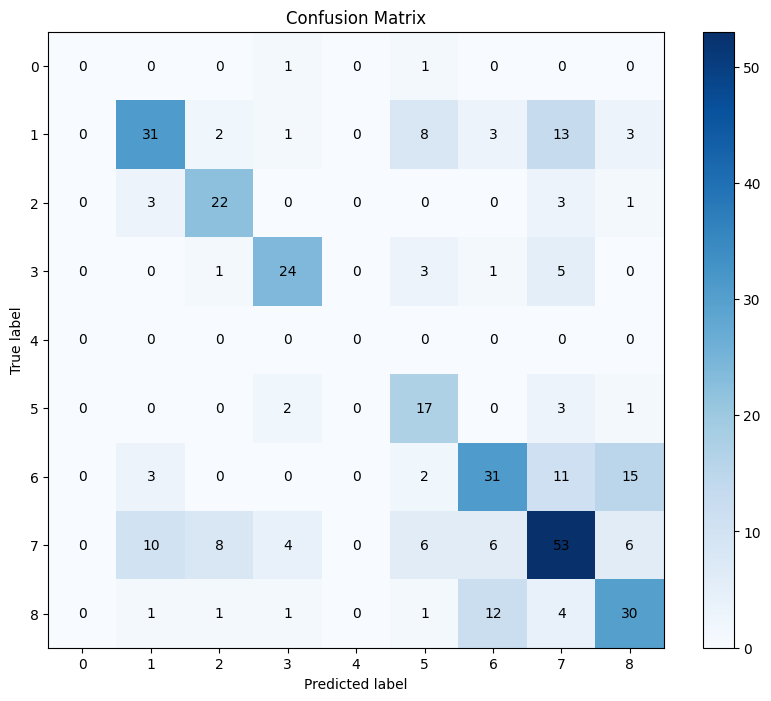

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Assuming pred_classes and true_classes are numpy arrays of class indices
# Compute confusion matrix
cm = np.zeros((9, 9), dtype=int)
for pred_class, true_class in zip(pred_classes, true_classes):
    cm[true_class, pred_class] += 1

# Plot confusion matrix with counts
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

# Add count values to each cell
for i in range(9):
    for j in range(9):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(np.arange(9))
plt.yticks(np.arange(9))
plt.show()

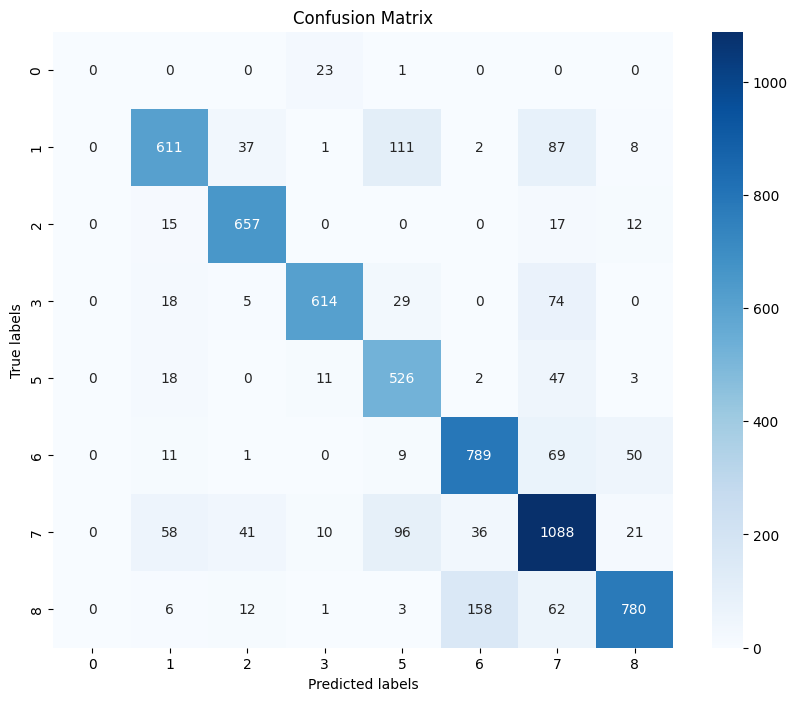

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Flatten the predicted and true classes arrays
pred_classes_flat = pred_classes.flatten()
true_classes_flat = true_classes.flatten()

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes_flat, pred_classes_flat)

# Plotting the confusion matrix with seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_classes_flat), yticklabels=np.unique(true_classes_flat))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
total_predictions = np.sum(conf_matrix)
print(total_predictions)

6230


In [ ]:
print(true_classes.shape)

(178, 35)


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

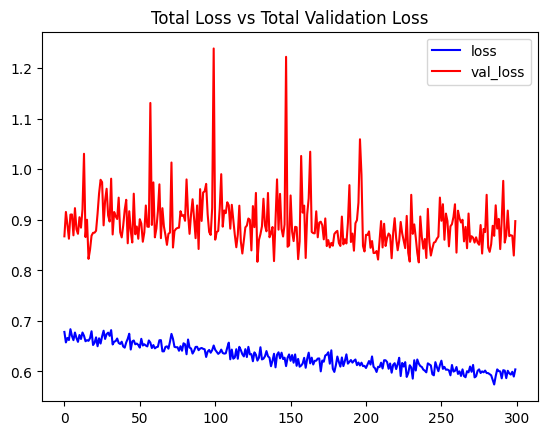

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

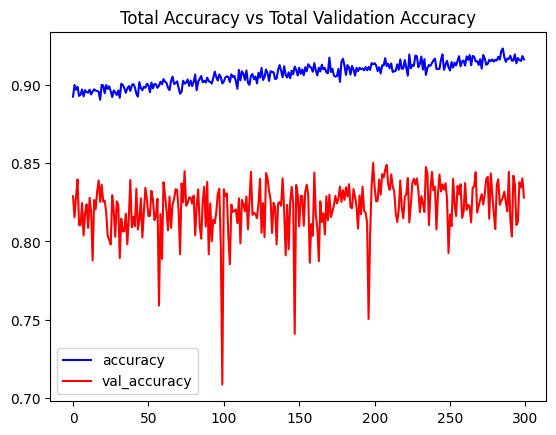

In [ ]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')